<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Inh"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/ThreeCellClass/Inh/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

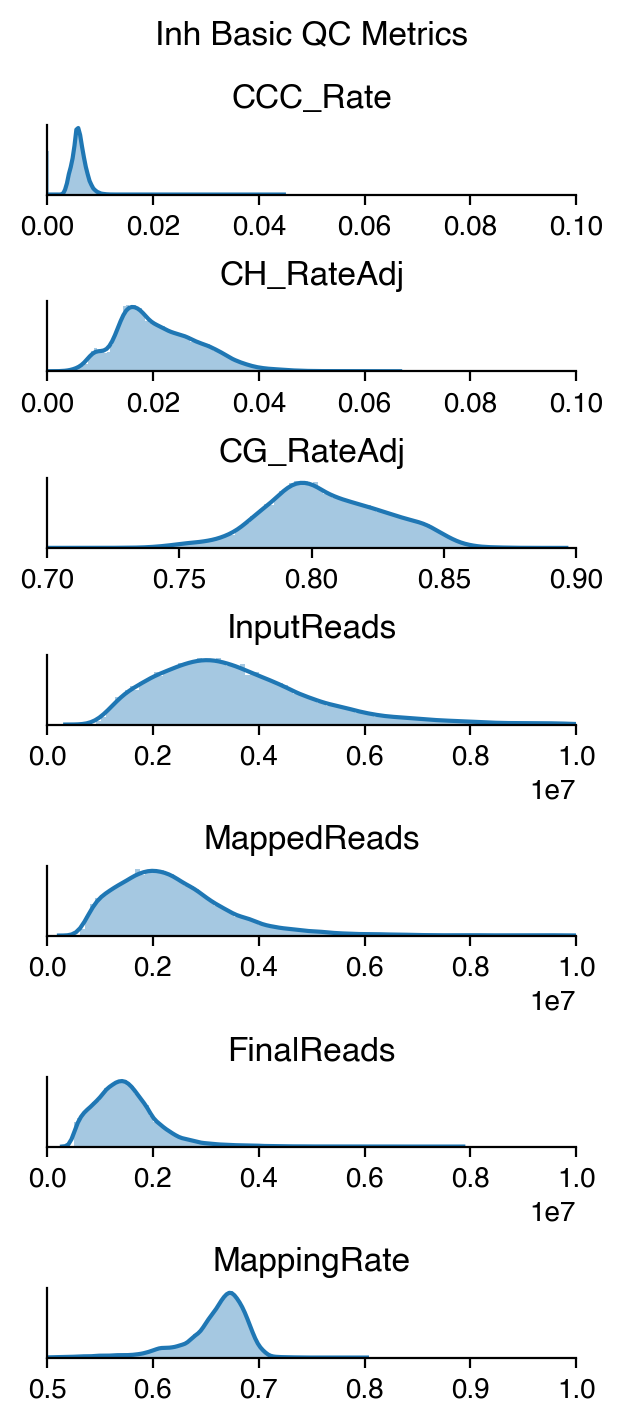

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

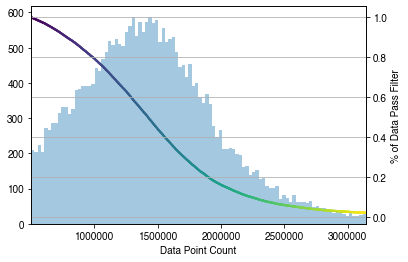

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 28343/28343 (100.0%)
CG_RateAdj passed 28343/28343 (100.0%)
CH_RateAdj passed 28343/28343 (100.0%)
FinalReads passed 28343/28343 (100.0%)
MappingRate passed 28343/28343 (100.0%)
Overall passed 28343/28343 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 127
171207 209
171212 27
171213 213
171214 932
171219 1227
180104 214
180109 685
180110 1087
180111 461
180119 233
180122 147
180123 141
180129 115
180130 182
180205 128
180206 125
180208 693
180212 501
180213 186
180220 456
180222 484
180226 208
180227 176
180305 156
180306 242
180312 164
180313 97
180319 47
180320 286
180326 188
180329 420
180402 361
180403 424
180405 768
180409 220
180410 227
180412 137
180416 141
180417 111
180419 123
180423 146
180424 93
180426 171
180430 165
180501 166
180514 98
180529 146
180605 131
180612 172
180724 172
180806 652
180911 1107
180917 758
180925 1206
181002 169
181008 175
181009 163
181015 1216
181016 1136
181022 123
181023 118
181204 731
181206 966
181210 201
181218 617
181220 1154
190108 92
190117 83
190122 200
190124 193
190131 148
190205 285
190207 1103
190212 136
190214 205
190219 108
190305 193
190307 129
190625 59
190627 91
190711 150
190716 147


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 3322 865.1%
ad002 3584 933.3%
ad004 3619 942.4%
ad006 3620 942.7%
ad007 3548 924.0%
ad008 3589 934.6%
ad010 3552 925.0%
ad012 3509 913.8%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,...,0.656195,A1,CEMBA190625-10E-1,0,0,0,0,190625,10,True
10E_M_109,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005839,0.772664,0.771329,0.019089,0.013327,796516.0,1890630,1203975.0,10E,...,0.636812,B11,CEMBA190625-10E-1,10,1,20,3,190625,10,True
10E_M_1338,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007324,0.814799,0.813433,0.036182,0.029071,1703622.0,4685660,3101242.0,10E,...,0.661858,G11,CEMBA190625-10E-4,10,6,20,13,190625,10,True
10E_M_150,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005896,0.758085,0.756650,0.023756,0.017967,1579104.0,4109724,2710612.0,10E,...,0.659561,B5,CEMBA190625-10E-1,4,1,9,2,190625,10,True
10E_M_1518,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007294,0.818669,0.817337,0.036374,0.029293,1972895.0,5551200,3483428.0,10E,...,0.627509,A10,CEMBA190627-10E-1,9,0,19,1,190627,10,True
10E_M_1526,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004817,0.764397,0.763256,0.016351,0.011589,1078279.0,2741252,1794215.0,10E,...,0.654524,A11,CEMBA190627-10E-1,10,0,21,1,190627,10,True
10E_M_1528,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008194,0.829654,0.828246,0.040873,0.032949,1822062.0,5265826,3262298.0,10E,...,0.619523,A11,CEMBA190627-10E-2,10,0,20,1,190627,10,True
10E_M_1540,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006985,0.815133,0.813832,0.038630,0.031868,2057810.0,6132020,3987159.0,10E,...,0.650220,A2,CEMBA190627-10E-1,1,0,2,1,190627,10,True
10E_M_1560,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.009671,0.826325,0.824629,0.049657,0.040376,2043560.0,5771766,3800581.0,10E,...,0.658478,A4,CEMBA190627-10E-2,3,0,7,0,190627,10,True
